In [172]:
!pip install vaderSentiment

In [173]:
import pandas as pd
import yfinance as yf
from datetime import timedelta
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [215]:
df = pd.read_csv('analyst_ratings_processed.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
stock_list = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA", "META", "NVDA", "BRK.B", "JNJ", "V", "PG", "UNH", "HD", "PEP", "KO", "MA", "ABBV", "AVGO", "MRK", "XOM", "CVX", "NKE", "WMT", "T", "CMCSA", "DIS", "MCD", "PYPL", "AMD", "NFLX", "ADP", "IBM", "CRM", "INTC", "ORCL", "TMO", "MDT", "LLY", "COST", "VZ"]
df = df[(df['stock'].isin(stock_list))]
df.reset_index(inplace=True,drop=True)
df

,title,date,stock
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10 11:33:00-04:00,AAPL
1,10 Biggest Price Target Changes For Wednesday,2020-06-10 08:14:00-04:00,AAPL
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10 07:53:00-04:00,AAPL
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10 07:19:00-04:00,AAPL
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10 06:27:00-04:00,AAPL
...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09 03:48:00-04:00,XOM
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02 04:34:00-04:00,XOM
49229,Energy ETFs: A Credible Value Destination,2018-06-29 09:55:00-04:00,XOM
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27 14:53:00-04:00,XOM


In [216]:
stock_df = pd.DataFrame()
for i in tqdm(stock_list):
  date_min = pd.to_datetime(df[(df['stock']==i)]['date'].min()) - timedelta(days=5)
  date_max = pd.to_datetime(df[(df['stock']==i)]['date'].max()) + timedelta(days=5)
  start_date = pd.to_datetime(date_min)
  end_date = pd.to_datetime(date_max)
  temp_df = yf.download(i, start=start_date, end=end_date, progress=False)
  temp_df = temp_df.reset_index()
  temp_df['stock'] = i
  # Rename columns to lowercase and more standardized names if needed
  temp_df.columns = ['date', 'adj_close', 'close', 'high', 'low', 'open', 'volume','stock']

  stock_df = pd.concat([stock_df,temp_df])

stock_df

  0%|          | 0/40 [00:00<?, ?it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSFT']: ValueError('Naive time - no tzinfo set')
 10%|█         | 4/40 [00:00<00:01, 31.93it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['META']: ValueError('Naive time - no tzinfo set')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
 48%|████▊     | 19/40 [00:01<00:01, 14.17it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CVX']: ValueError('Naive time - no tzinfo set')
 52%|█████▎    | 21/40 [00:01<00:01, 14.87it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['NKE']: ValueError('Naive time - no tzinfo set')
 68%|██████▊   | 27/40 [00:01<00:00, 15.28it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PYPL']: ValueError('Naive time - no tzinfo set')
 92%|█████████▎| 37/40 [00:02<00:00, 12.42it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['COST']: ValueError('Naive time - no tzinfo s

,date,adj_close,close,high,low,open,volume,stock
0,2020-03-04,73.549416,75.684998,75.849998,73.282501,74.110001,219178400.0,AAPL
1,2020-03-05,71.163696,73.230003,74.887497,72.852501,73.879997,187572800.0,AAPL
2,2020-03-06,70.218628,72.257500,72.705002,70.307503,70.500000,226176800.0,AAPL
3,2020-03-09,64.664902,66.542503,69.522499,65.750000,65.937500,286744800.0,AAPL
4,2020-03-10,69.322166,71.334999,71.610001,67.342499,69.285004,285290000.0,AAPL
...,...,...,...,...,...,...,...,...
2052,2020-06-10,44.994450,58.049999,58.230000,57.700001,57.900002,13649100.0,VZ
2053,2020-06-11,43.754295,56.450001,57.939999,56.400002,57.480000,23412500.0,VZ
2054,2020-06-12,43.816299,56.529999,56.810001,55.790001,56.630001,17129000.0,VZ
2055,2020-06-15,43.521767,56.150002,56.540001,55.279999,55.730000,14826800.0,VZ


# First Approach
We determine the change for the single day of when the news was released


In [217]:
# Convert date columns to a common format for merging
df['date'] = pd.to_datetime(df['date'], utc=True).dt.strftime('%Y-%m-%d')
stock_df['date'] = pd.to_datetime(stock_df['date'], utc=True).dt.strftime('%Y-%m-%d')
# Merge df with stocks_df to add open and close prices
df = df.merge(stock_df[['date', 'stock', 'open', 'close']], on=['date', 'stock'], how='left')

# Rename columns if needed to match the expected output
df.rename(columns={'open': 'open_price', 'close': 'close_price'}, inplace=True)

df['change'] = df['close_price'] - df['open_price']

df['movement'] = np.where(df['change'] > 0, 'up', 'down')

df['movement'] = df['movement'].apply(lambda x: 1 if x == 'up' else 0)

df_preprocessed = df

df

,title,date,stock,open_price,close_price,change,movement
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,1
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,0
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,1
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,1


In [218]:
df_preprocessed

,title,date,stock,open_price,close_price,change,movement
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,1
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,0
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,1
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,1


# Without using a built in function for sentiment generation

In [198]:
tfidf = TfidfVectorizer(max_features=500, stop_words='english')  # Limit to 500 features for simplicity
X_text = tfidf.fit_transform(df['title'])

X = X_text
y = df['movement']


In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [200]:
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

KeyboardInterrupt: 

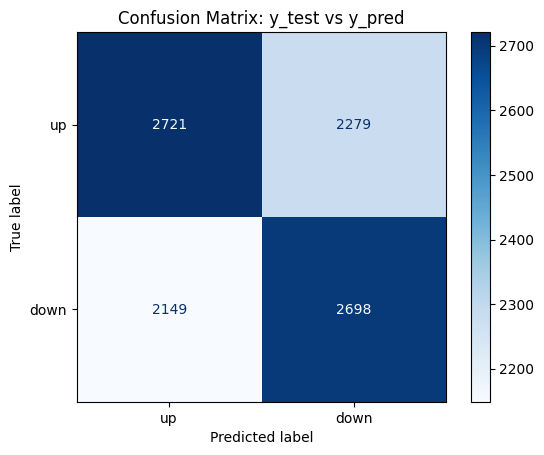

In [180]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up', 'down'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: y_test vs y_pred')
plt.show()

# With Vader

In [203]:
df = df_preprocessed
df_preprocessed

,title,date,stock,open_price,close_price,change,movement
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1
...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,1
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,0
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,1
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,1


Accuracy: 0.5086828475677871
              precision    recall  f1-score   support

           0       0.50      0.79      0.61      4847
           1       0.54      0.23      0.33      5000

    accuracy                           0.51      9847
   macro avg       0.52      0.51      0.47      9847
weighted avg       0.52      0.51      0.47      9847



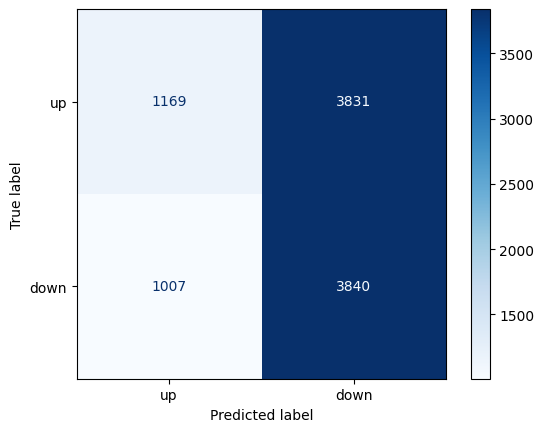

In [204]:
# Initialize VADER for sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment score for each article
df['sentiment_score'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
# Define features (X) and target (y)
X = df[['sentiment_score']]
y = df['movement']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train the Random Forest classifier on resampled data
rf_clf = RandomForestClassifier(random_state=42, class_weight=None)  # No need for class weights after SMOTE
rf_clf.fit(X_train, y_train)
# Predict on the test set
y_pred = rf_clf.predict(X_test)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # 1 = up, 0 = down
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["up", "down"])
disp.plot(cmap="Blues")

# In a second approach, if the sentiment score is between -0.4 and, 0.4, we will use a 'neutral' movement category for it

In [206]:
df_preprocessed

,title,date,stock,open_price,close_price,change,movement,sentiment_score
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.5574
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.0000
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.2023
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.0000
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.3818
...,...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,1,0.0000
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,0,-0.5719
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,1,0.5423
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,1,0.0000


In [205]:
df = df_preprocessed
df

,title,date,stock,open_price,close_price,change,movement,sentiment_score
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.5574
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.0000
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.2023
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.0000
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,0.3818
...,...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,1,0.0000
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,0,-0.5719
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,1,0.5423
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,1,0.0000


In [210]:
# Initialize VADER for sentiment analysis
analyzer = SentimentIntensityAnalyzer()

# Calculate sentiment score for each article
df['sentiment_score'] = df['title'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [211]:
def classify_movement(sentiment_score):
    if sentiment_score > 0.05:
        return 'up'
    elif sentiment_score < -0.05:
        return 'down'
    else:
        return 'neutral'

# Apply the classification function to the DataFrame
df['movement'] = df['sentiment_score'].apply(classify_movement)
movement_mapping = {'up': 1, 'neutral': 1, 'down': -1}
df['movement_label'] = df['movement'].map(movement_mapping)

# Prepare the features (e.g., sentiment score) and labels
X = df[['sentiment_score']]
y = df['movement']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [212]:
df.head()

,title,date,stock,open_price,close_price,change,movement,sentiment_score,movement_label
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,up,0.5574,1
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,neutral,0.0000,1
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,up,0.2023,1
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,neutral,0.0000,1
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,up,0.3818,1


In [213]:
# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# Train the model
rf_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_clf.predict(X_test)


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

        down       1.00      1.00      1.00      1510
     neutral       1.00      1.00      1.00      5107
          up       1.00      1.00      1.00      3230

    accuracy                           1.00      9847
   macro avg       1.00      1.00      1.00      9847
weighted avg       1.00      1.00      1.00      9847



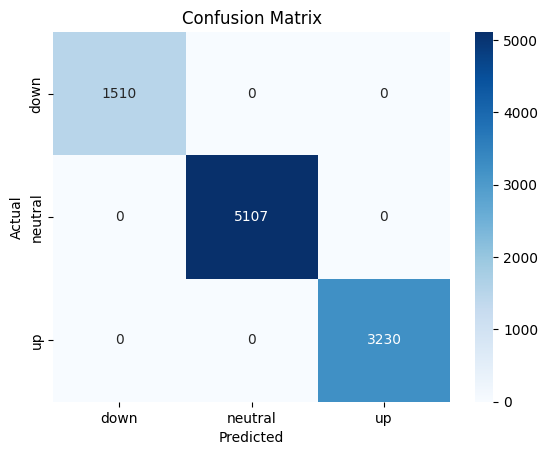

In [214]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['down', 'neutral', 'up']))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['down', 'neutral', 'up'], yticklabels=['down', 'neutral', 'up'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


We can see that adding the neutral category substantially increases the accuracy and gives us a perfect accuracy. This suggests that the model has a lot of class imbalance, meaning that a lot of the target variables lie in the neutral zone

# Using a neutral label in the stock price change

In [189]:
df = df_preprocessed
df

,title,date,stock,open_price,close_price,change,movement,sentiment_score,movement_label
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,up,0.5574,1
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,neutral,0.0000,1
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,up,0.2023,1
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,neutral,0.0000,1
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,up,0.3818,1
...,...,...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,neutral,0.0000,1
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,down,-0.5719,-1
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,up,0.5423,1
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,neutral,0.0000,1


In [219]:
# Function to update the movement label based on the 'change' value
def update_movement(change, label_price):
    threshold = 0.01 * label_price
    if change > threshold:
        return 1  # Up
    elif change < -threshold:
        return -1  # Down
    else:
        return 0  # Neutral

# Apply the function to update the movement column
df['movement'] = df.apply(lambda row: update_movement(row['change'], row['open_price']), axis=1)

# Display the updated DataFrame
print(df)


                                                   title        date stock  \
0      Tech Stocks And FAANGS Strong Again To Start D...  2020-06-10  AAPL   
1          10 Biggest Price Target Changes For Wednesday  2020-06-10  AAPL   
2      Benzinga Pro's Top 5 Stocks To Watch For Wed.,...  2020-06-10  AAPL   
3      Deutsche Bank Maintains Buy on Apple, Raises P...  2020-06-10  AAPL   
4      Apple To Let Users Trade In Their Mac Computer...  2020-06-10  AAPL   
...                                                  ...         ...   ...   
49227  ExxonMobil Announces Rovuma LNG Phase 1 Develo...  2018-07-09   XOM   
49228  ExxonMobil Hires Crude Trader Michael Huang in...  2018-07-02   XOM   
49229          Energy ETFs: A Credible Value Destination  2018-06-29   XOM   
49230  Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...  2018-06-27   XOM   
49231  Caution Remains On Wall Street Even As Concern...  2018-06-27   XOM   

       open_price  close_price    change  movement  
0       86

In [220]:
tfidf = TfidfVectorizer(max_features=500, stop_words='english')  # Limit to 500 features for simplicity
X_text = tfidf.fit_transform(df['title'])

X = X_text
y = df['movement']

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [222]:
rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5692088961104905
              precision    recall  f1-score   support

          -1       0.36      0.25      0.29      1889
           0       0.65      0.79      0.71      5832
           1       0.36      0.24      0.29      2126

    accuracy                           0.57      9847
   macro avg       0.46      0.43      0.43      9847
weighted avg       0.53      0.57      0.54      9847



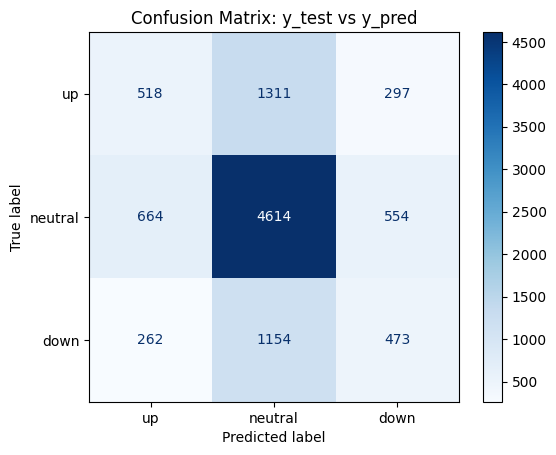

In [223]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0,-1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up','neutral', 'down'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: y_test vs y_pred')
plt.show()

# We see now, how Logistic Regression works on this data

In [224]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [225]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5992688128363969
              precision    recall  f1-score   support

          -1       0.37      0.08      0.13      1889
           0       0.62      0.95      0.75      5832
           1       0.45      0.10      0.16      2126

    accuracy                           0.60      9847
   macro avg       0.48      0.38      0.35      9847
weighted avg       0.53      0.60      0.50      9847



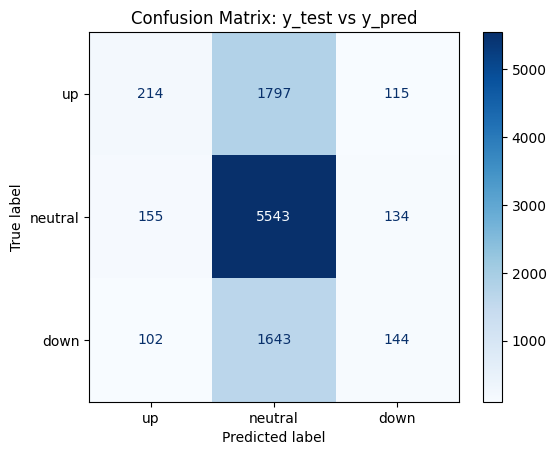

In [226]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0,-1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up','neutral', 'down'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: y_test vs y_pred')
plt.show()

# We will also see how SVM performs

In [227]:
from sklearn.svm import SVC

# Initialize the SVM classifier
svm_clf = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)

# Train the model
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_clf.predict(X_test)

In [228]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5956128770183813
              precision    recall  f1-score   support

          -1       0.40      0.02      0.04      1889
           0       0.60      0.99      0.75      5832
           1       0.45      0.04      0.07      2126

    accuracy                           0.60      9847
   macro avg       0.48      0.35      0.28      9847
weighted avg       0.53      0.60      0.46      9847



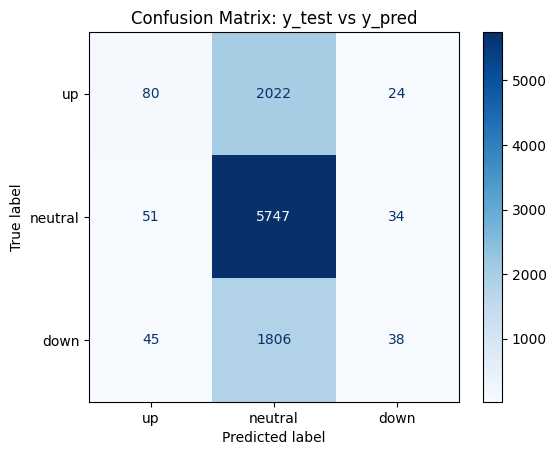

In [229]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0,-1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up','neutral', 'down'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: y_test vs y_pred')
plt.show()

# Changing the time frame to 3 days

In [230]:
# Ensure consistent datetime formats
df['date'] = pd.to_datetime(df['date']).dt.date  # Remove time for simplicity
stock_df['date'] = pd.to_datetime(stock_df['date']).dt.date

In [231]:
# Add -1 day and +1 day columns
df['date_minus_1'] = df['date'] - pd.Timedelta(days=1)
df['date_plus_1'] = df['date'] + pd.Timedelta(days=1)


In [232]:
# Merge for -1 day prices
df = df.merge(
    stock_df[['date', 'stock', 'close']].rename(columns={'close': 'close_minus_1'}),
    left_on=['date_minus_1', 'stock'],
    right_on=['date', 'stock'],
    how='left'
)

# Merge for +1 day prices
df = df.merge(
    stock_df[['date', 'stock', 'close']].rename(columns={'close': 'close_plus_1'}),
    left_on=['date_plus_1', 'stock'],
    right_on=['date', 'stock'],
    how='left'
)

# Drop redundant date columns after merging
df.drop(columns=['date_minus_1', 'date_plus_1'], inplace=True)


In [233]:
df

,title,date_x,stock,open_price,close_price,change,movement,date_y,close_minus_1,date,close_plus_1
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998
...,...,...,...,...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,0,NaN,NaN,2018-07-10,83.660004
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,0,NaN,NaN,2018-07-03,82.239998
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,0,2018-06-28,81.970001,NaN,NaN
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,0,2018-06-26,80.639999,2018-06-28,81.970001


In [234]:
# Calculate change from -1 day to +1 day
df['change_2'] = df['close_plus_1'] - df['close_minus_1']

# Define movement categories
df['movement_2'] = df['change_2'].apply(lambda x: 'up' if x > 0 else ('down' if x < 0 else 'neutral'))


In [235]:
df

,title,date_x,stock,open_price,close_price,change,movement,date_y,close_minus_1,date,close_plus_1,change_2,movement_2
0,Tech Stocks And FAANGS Strong Again To Start D...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998,-2.022499,down
1,10 Biggest Price Target Changes For Wednesday,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998,-2.022499,down
2,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998,-2.022499,down
3,"Deutsche Bank Maintains Buy on Apple, Raises P...",2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998,-2.022499,down
4,Apple To Let Users Trade In Their Mac Computer...,2020-06-10,AAPL,86.974998,88.209999,1.235001,1,2020-06-09,85.997498,2020-06-11,83.974998,-2.022499,down
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49227,ExxonMobil Announces Rovuma LNG Phase 1 Develo...,2018-07-09,XOM,82.809998,82.900002,0.090004,0,NaN,NaN,2018-07-10,83.660004,NaN,neutral
49228,ExxonMobil Hires Crude Trader Michael Huang in...,2018-07-02,XOM,81.889999,81.760002,-0.129997,0,NaN,NaN,2018-07-03,82.239998,NaN,neutral
49229,Energy ETFs: A Credible Value Destination,2018-06-29,XOM,82.449997,82.730003,0.280006,0,2018-06-28,81.970001,NaN,NaN,NaN,neutral
49230,Algerian Gov't.-Owned Sonatrach CEO Amine Mazo...,2018-06-27,XOM,81.059998,81.709999,0.650002,0,2018-06-26,80.639999,2018-06-28,81.970001,1.330002,up


In [236]:
movement_mapping = {'up': 1, 'down': -1, 'neutral': 0}
df['movement_label_2'] = df['movement_2'].map(movement_mapping)

In [237]:
tfidf = TfidfVectorizer(max_features=500, stop_words='english')  # Limit to 500 features for simplicity
X_text = tfidf.fit_transform(df['title'])

X = X_text
y = df['movement_label_2']

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [239]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = log_reg.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [240]:
y_test

,movement_label_2
35342,1
10134,1
42602,1
2868,0
10439,0
...,...
22670,1
17534,0
11607,0
9279,-1


In [241]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.4480552452523611
              precision    recall  f1-score   support

          -1       0.36      0.17      0.23      2591
           0       0.48      0.70      0.57      4058
           1       0.41      0.36      0.38      3198

    accuracy                           0.45      9847
   macro avg       0.42      0.41      0.39      9847
weighted avg       0.43      0.45      0.42      9847



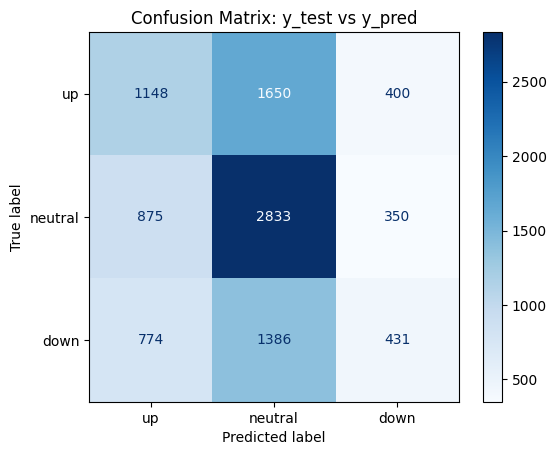

In [242]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0,-1])

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['up','neutral', 'down'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: y_test vs y_pred')
plt.show()